<a href="https://colab.research.google.com/github/Emma-Cap/Deep-Learning-Project/blob/main/LAVORO%20FINITO!!!!!!!!!!!.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Facial Recognition for Age Group Categorization**


## **Loading of required libraries**

In [ ]:
import zipfile
import os
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import math
import cv2
import numpy as np
import torchvision.transforms as transforms
from tqdm import tqdm
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from torchvision import transforms, models
import torch
import seaborn as sns
from sklearn.model_selection import train_test_split
import shutil
from transformers import AutoImageProcessor, AutoModelForImageClassification, TrainingArguments, Trainer
from torch.utils.data import Dataset, DataLoader
import torch
from sklearn.metrics import classification_report, confusion_matrix
import torch.nn as nn
from torch.optim import Adam
import time


## **Loading data**

The dataset used in this study is sourced from Kaggle's Faces Age Detection Dataset: [Age Detection from Images](https://www.kaggle.com/datasets/arashnic/faces-age-detection-dataset). It consists of high-quality images of human faces, annotated with labels corresponding to three age categories:

- Young
- Middle-aged
- Old

Each image file is associated with a unique identifier and a corresponding age label. This dataset seems to be well-suited for age classification tasks as it captures a variety of facial features, expressions, and lighting conditions.


---



**Objective of the Study**:

The primary objective of this study is to develop and evaluate machine learning models for classifying facial images into one of the three predefined age categories. This will involve leveraging on some architectures, including fine-tuning a Vision Transformer and adapting a pre-trained AlexNet model, to optimize performance on age classification tasks. The study aims to compare these approaches and identify the most effective method for extracting age-related features from facial images.  

In [ ]:
# percorso del file zip
zip_path = '/content/archive.zip'
extract_path = '/content/dataset'

# file zip
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# contenuto delle directory
for root, dirs, files in os.walk(extract_path):
    print(f"In directory: {root}")
    print(f"Cartelle: {dirs}")

In directory: /content/dataset
Cartelle: ['faces_02', 'faces']
In directory: /content/dataset/faces_02
Cartelle: ['part3']
In directory: /content/dataset/faces_02/part3
Cartelle: []
In directory: /content/dataset/faces
Cartelle: ['Train']
In directory: /content/dataset/faces/Train
Cartelle: []




---


## **Data Exploratory Analysis**

This below code  selects 6 random images from the dataset and shows them alongside their age category labels. I start by loading the annotations file with *pandas.read_csv()* and then use *sample()* to pick a random subset of rows. For each image, the file path is built using *os.path.join()*, and the image is opened with *PIL.Image.open()*. The images are displayed in a grid created with *matplotlib.pyplot.subplots()*, and any unused cells are hidden to maintain a clean layout.

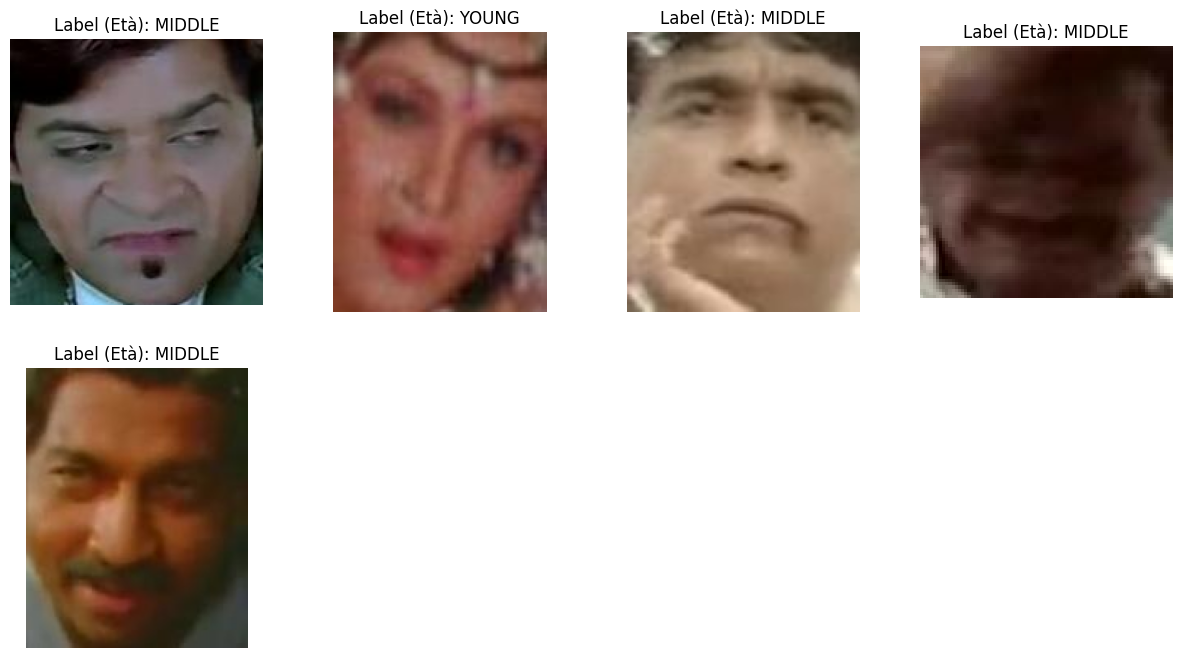

In [ ]:
# Percorso del file CSV e della cartella immagini
annotations_file = '/content/dataset/faces/train.csv'
images_dir = '/content/dataset/faces/Train'

annotations = pd.read_csv(annotations_file)

# 6 immagini
sample_images = annotations.sample(6)

# Colonne per mostrare le immagini affiancate
columns = 3

# numero di righe necessario
rows = math.ceil(len(sample_images) / columns)

fig, axes = plt.subplots(rows, columns, figsize=(15, rows * 4))
axes = axes.flatten()  # Rende la griglia un array monodimensionale per iterazione semplice

for idx, (ax, (_, row)) in enumerate(zip(axes, sample_images.iterrows())):
    image_path = os.path.join(images_dir, row['ID'])  # colonna 'ID' per il nome del file
    label = row['Class']  # colonna 'Class' per la label

    img = Image.open(image_path)
    ax.imshow(img)
    ax.set_title(f"Label (Età): {label}")
    ax.axis('off')


for ax in axes[len(sample_images):]:
    ax.axis('off')

# figura finale
plt.tight_layout()
plt.show()


Then to visualize the class distribution of the dataset I implemented the code below, highlighting the imbalance among the age groups.

- *annotations['Class'].value_counts().sort_index()* computes the number of samples per age category, sorted alphabetically.
- The matplotlib *plot(kind='bar')* function is used to create a bar chart showing the number of images in each class.


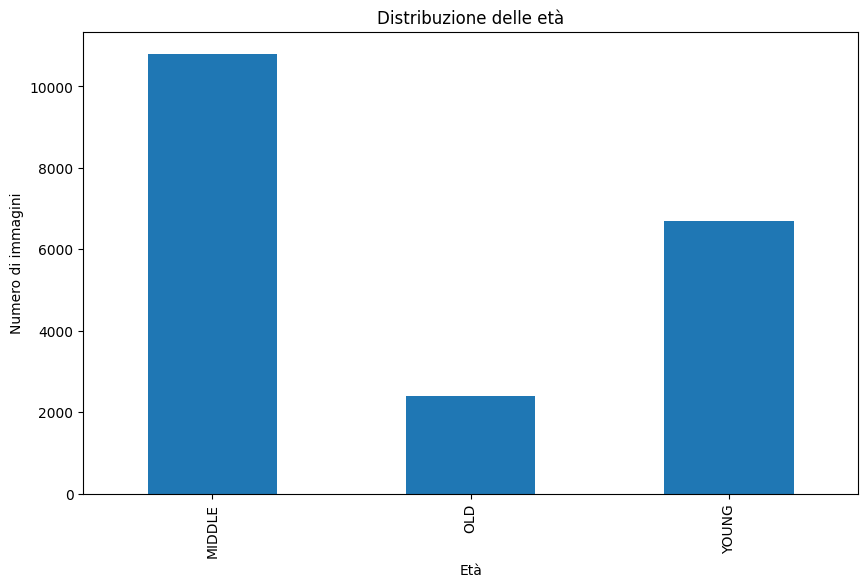

In [ ]:
# Distribuzione delle età
age_distribution = annotations['Class'].value_counts().sort_index()

# Plot distribuzione
plt.figure(figsize=(10, 6))
age_distribution.plot(kind='bar')
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Number of Immagies')
plt.show()

The resulting bar chart clearly shows that the $middle$ class dominates the dataset, followed by $young$, with $old$ having significantly fewer samples. This imbalance could potentially later impair the performance of the model, reason why I will later adjust it.



---


### **Dataset cleaning**


Here, I implemented a filtering step to remove low-quality images from the dataset. Specifically, I used:
 - $Laplacian$ $variance$ via *cv2.Laplacian*:  This method detects image noise by calculating the second-order derivatives of pixel intensities. The Laplacian variance measures the overall sharpness of an image—low variance indicates blurriness, while high variance suggests sharpness or excessive noise. Images with a variance exceeding a defined noise threshold (500) were filtered out, helping to eliminate overly noisy images that could degrade model performance.
 - $Resolution$ $check$ using *PIL.Image*:
Images smaller than 100x100 pixels were excluded. Low-resolution images often lack the level of detail required for effective feature extraction and can negatively impact the performance of deep learning models.

The filtered images and updated annotations were then saved in the *final_images directory*, leaving only high-quality, detailed images for subsequent steps.

In [ ]:
output_dir = 'final_images'
os.makedirs(output_dir, exist_ok=True)

# **1. Filtrare immagini con rumore elevato**
noise_threshold = 500
low_quality_images = []

for img_name in annotations['ID']:
    img_path = os.path.join(images_dir, img_name)
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

    if img is not None:
        laplacian = cv2.Laplacian(img, cv2.CV_64F)
        variance = laplacian.var()
        if variance > noise_threshold:
            low_quality_images.append(img_name)

# **2. Filtrare immagini a bassa risoluzione**
for img_name in annotations['ID']:
    img_path = os.path.join(images_dir, img_name)
    try:
        with Image.open(img_path) as img:
            width, height = img.size
            resolution = width * height
            if resolution < 10000:  # Risoluzione bassa: 100x100
                low_quality_images.append(img_name)
    except Exception as e:
        print(f"Errore nell'aprire {img_path}: {e}")
        low_quality_images.append(img_name)

# Rimuoviamo duplicati dalla lista
low_quality_images_set = set(low_quality_images)

# Rimuoviamo tutte le immagini di bassa qualità dal DataFrame
filtered_annotations = annotations[~annotations['ID'].isin(low_quality_images_set)]
print(f"Immagini di bassa qualità rimosse: {len(low_quality_images_set)}")
print(f"Immagini rimanenti: {len(filtered_annotations)}")

# **3. Salvare le immagini rimanenti**
for idx, row in filtered_annotations.iterrows():
    img_name = row['ID']
    img_path = os.path.join(images_dir, img_name)
    output_path = os.path.join(output_dir, img_name)
    try:
        with Image.open(img_path) as img:
            img.save(output_path)
    except Exception as e:
        print(f"Errore nel salvare {img_path}: {e}")

print(f"Immagini salvate nella directory finale: {len(filtered_annotations)}")

# **4. Salvare il nuovo DataFrame con le annotazioni aggiornate**
filtered_annotations_file = os.path.join(output_dir, 'filtered_annotations.csv')
filtered_annotations.to_csv(filtered_annotations_file, index=False)
print(f"Annotazioni aggiornate salvate in: {filtered_annotations_file}")

Immagini di bassa qualità rimosse: 11692
Immagini rimanenti: 8214
Immagini salvate nella directory finale: 8214
Annotazioni aggiornate salvate in: final_images/filtered_annotations.csv


In this below section, I refined the dataset further by eliminating both overly dark and low-detail images. For this, I used two key metrics:

- $Brightness Analysis$: The average brightness of each image was calculated using *np.mean()* on grayscale images. A brightness threshold of 50 was set, below which images were considered too dark to be meaningful.

- $Laplacian Variance$: I reused the Laplacian variance method from the previous step, but with a different goal. Here, images with a variance below 100 were deemed to have insufficient detail and were removed. This step helps identify and eliminate blurry images that might still have passed the initial noise check.

The code iterated over all images and filtered out those not meeting either quality metric. These images were removed both from the annotations and the directory. The updated annotations were saved back to filtered_annotations.csv, ensuring consistency for future steps.

This ensures that the dataset now consists only of bright, sharp, and detailed images, which is critical for improving the model's ability to generalize effectively during training.

In [ ]:
filtered_annotations_file = "final_images/filtered_annotations.csv"
images_dir = "final_images"

# Caricare le annotazioni
filtered_annotations = pd.read_csv(filtered_annotations_file)

# Parametri per il filtraggio
brightness_threshold = 50  # Soglia di luminosità media
laplacian_threshold = 100  # Soglia di varianza Laplaciana per rilevare immagini poco dettagliate
low_quality_images = []

# **1. Rimuovere immagini scure e con bassa qualità**
for img_name in tqdm(filtered_annotations['ID'], desc="Filtraggio immagini scure e di bassa qualità"):
    img_path = os.path.join(images_dir, img_name)
    try:
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            # Controllo della luminosità media
            brightness = np.mean(img)
            # Controllo del dettaglio (varianza Laplaciana)
            laplacian_var = cv2.Laplacian(img, cv2.CV_64F).var()

            # Se immagine è troppo scura o di bassa qualità
            if brightness < brightness_threshold or laplacian_var < laplacian_threshold:
                low_quality_images.append(img_name)
    except Exception as e:
        print(f"Errore nel leggere l'immagine {img_name}: {e}")
        low_quality_images.append(img_name)

# Rimuovere le immagini di bassa qualità dalle annotazioni
filtered_annotations = filtered_annotations[~filtered_annotations['ID'].isin(low_quality_images)]
print(f"Immagini scure o di bassa qualità rimosse: {len(low_quality_images)}")
print(f"Immagini rimanenti: {len(filtered_annotations)}")

# Salvare le annotazioni aggiornate con lo stesso nome del file
filtered_annotations.to_csv(filtered_annotations_file, index=False)
print(f"Annotazioni aggiornate salvate in: {filtered_annotations_file}")

# Rimuovere le immagini di bassa qualità dalla directory
for img_name in tqdm(low_quality_images, desc="Rimozione immagini scure/bassa qualità"):
    img_path = os.path.join(images_dir, img_name)
    if os.path.exists(img_path):
        os.remove(img_path)

Filtraggio immagini scure e di bassa qualità: 100%|██████████| 8214/8214 [00:04<00:00, 1969.15it/s]


Immagini scure o di bassa qualità rimosse: 6448
Immagini rimanenti: 1766
Annotazioni aggiornate salvate in: final_images/filtered_annotations.csv


Rimozione immagini scure/bassa qualità: 100%|██████████| 6448/6448 [00:00<00:00, 43945.89it/s]



The code below highlights the difference in class distribution between the original and filtered datasets, showcasing how preprocessing impacted the dataset. Using *Seaborn bar plots*, I compared the counts of images per class before and after applying filters for low-quality images.

Key points:

- I leveraged *value_counts()* to calculate the class frequencies for both datasets and ensured the order of classes matched across the plots with *reindex()*.
-For better interpretation, I annotated each bar with its exact value using axes.text.


<ipython-input-7-43ac7265a8cd>:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
<ipython-input-7-43ac7265a8cd>:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


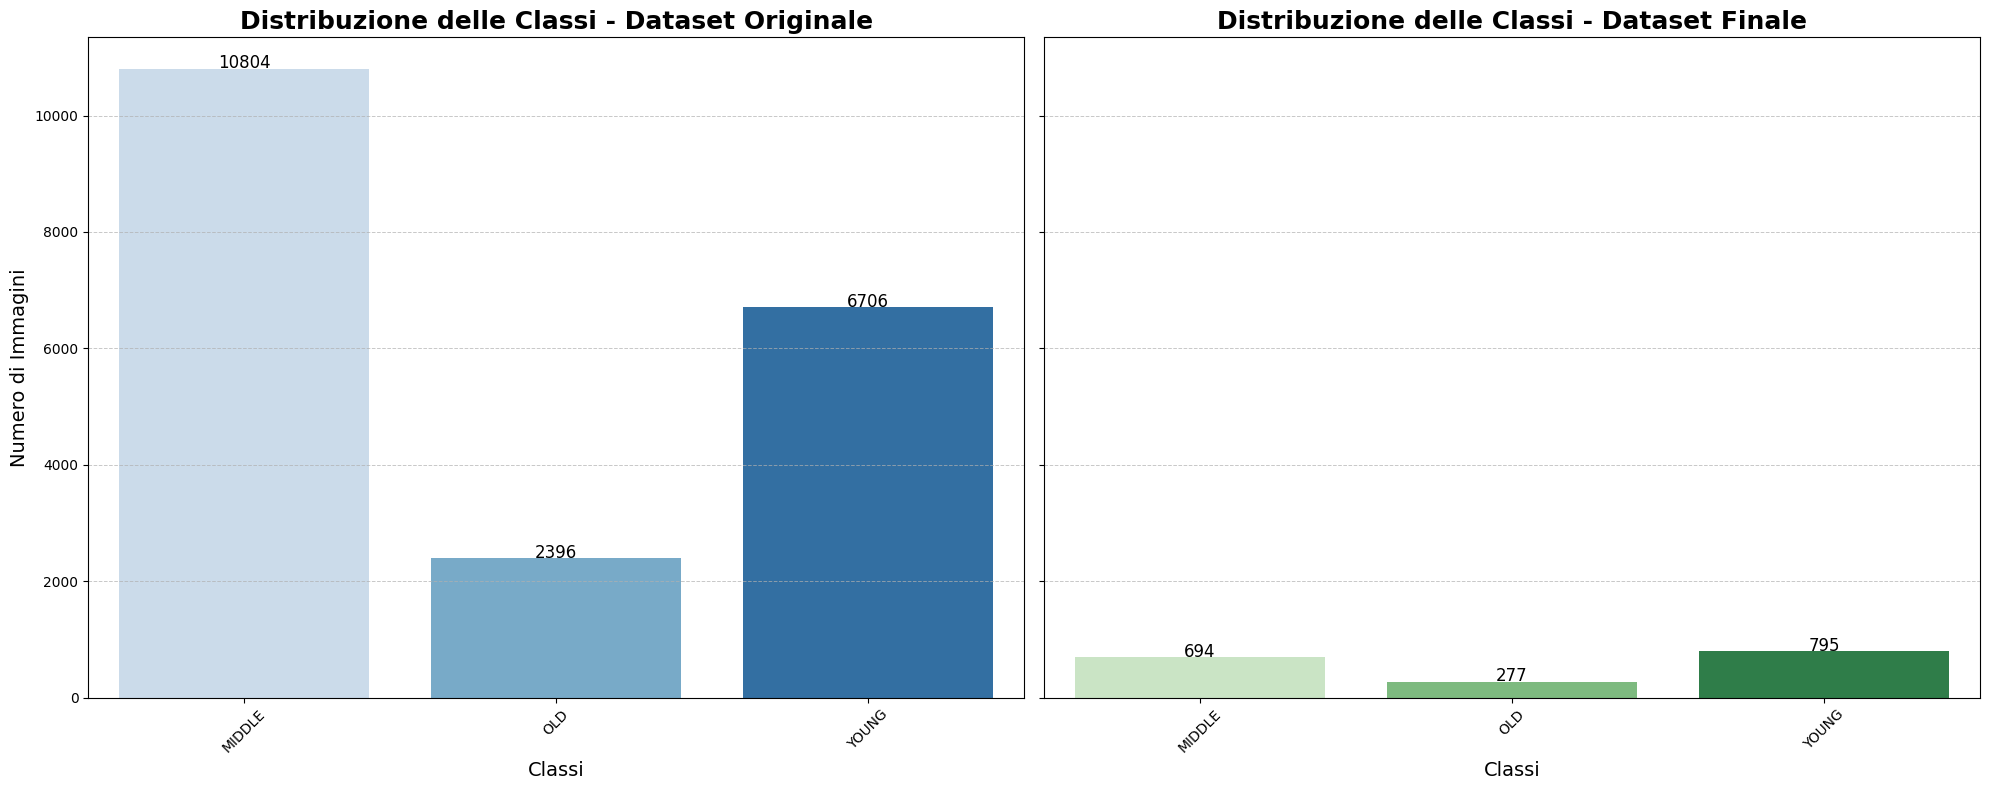

In [ ]:
filtered_annotations_file = "final_images/filtered_annotations.csv"
filtered_annotations = pd.read_csv(filtered_annotations_file)

# Distribuzione delle classi per dataset originale e finale
class_distribution_original = annotations['Class'].value_counts().sort_index()
class_distribution_final = filtered_annotations['Class'].value_counts().sort_index()

# Verificare che le classi originali e finali abbiano lo stesso ordine
class_distribution_original = class_distribution_original.reindex(class_distribution_final.index)

# Creare una figura con due subplot affiancati per il confronto
fig, axes = plt.subplots(1, 2, figsize=(20, 8), sharey=True)

# Colori per i plot
palette_original = sns.color_palette("Blues", len(class_distribution_original))
palette_final = sns.color_palette("Greens", len(class_distribution_final))

# Plot per il dataset originale
sns.barplot(
    x=class_distribution_original.index,
    y=class_distribution_original.values,
    palette=palette_original,
    ax=axes[0]
)
axes[0].set_title('Distribution of Classes - Original Dataset', fontsize=18, fontweight='bold')
axes[0].set_xlabel('Classes', fontsize=14)
axes[0].set_ylabel('Number of Images', fontsize=14)
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='y', linestyle='--', linewidth=0.7, alpha=0.7)

# Annotazioni per mostrare i valori sulle barre
for i, value in enumerate(class_distribution_original.values):
    axes[0].text(i, value + 10, str(value), ha='center', fontsize=12, color='black')

# Plot per il dataset finale
sns.barplot(
    x=class_distribution_final.index,
    y=class_distribution_final.values,
    palette=palette_final,
    ax=axes[1]
)
axes[1].set_title('Distribution of Classes - Final Dataset', fontsize=18, fontweight='bold')
axes[1].set_xlabel('Classes', fontsize=14)
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(axis='y', linestyle='--', linewidth=0.7, alpha=0.7)

# Annotazioni per mostrare i valori sulle barre
for i, value in enumerate(class_distribution_final.values):
    axes[1].text(i, value + 10, str(value), ha='center', fontsize=12, color='black')

# Migliora il layout per evitare sovrapposizioni
plt.tight_layout()

# Mostra il grafico finale
plt.show()


The plots reveal a substantial decrease in the total number of images after filtering. The remaining dataset is relatively unbalanced.



---


### **Data Augmentation**

This implementation is focused on addressing the slight imbalance in the dataset by augmenting the $old$ class to reach a target of 600 ish images, starting from its current count. To ensure the augmented images are of high quality, I’ve prioritized the selection of images based on their resolution as a proxy for quality, leveraging the following key steps:

- Annotation Filtering:
I first load the *filtered_annotations.csv* file and filter for the $old$ class. This provides the baseline count of old images and calculates how many augmentations are required to hit the target.

- Quality-Based Image Selection:
Using *Pillow*, I compute the resolution (width × height) of each image in the $old$ class and sort them in descending order. Only the highest-quality images, based on resolution, are chosen for augmentation.

- Data Augmentation Pipeline:
The augmentations are created using *torchvision.transforms*, with transformations including:

 - Random horizontal flipping to add variability.
   - Random rotations within ±15 degrees.
   - Color adjustments such as brightness, contrast, and saturation.
   - Resizing all images to 224×224 for consistency.

  Each selected image generates exactly one new augmented sample, keeping the augmentation balanced.

 - Updating the Dataset:
For each augmented image:

   - I save it with a new name prefixed by "aug_" in the same directory (final_images) to avoid structural changes.
   - The corresponding annotation is appended to the dataset.

 Finally, the updated dataset, including both the original and augmented images, is saved back to *filtered_annotations.csv*.

- Efficiency:
The process checks if augmentation is necessary before proceeding. If the target count is already met, the script exits gracefully without redundant operations.

This approach ensures that the $old$ class reaches the desired count of 600 images ish while maintaining high data quality.

In [ ]:
final_images_dir = "final_images"  # Directory delle immagini originali
filtered_annotations_file = os.path.join(final_images_dir, "filtered_annotations.csv")

filtered_annotations = pd.read_csv(filtered_annotations_file)

# Configurare le trasformazioni per la data augmentation
augmentation_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.Resize((224, 224)),
])

# Filtrare solo la classe "OLD"
old_images = filtered_annotations[filtered_annotations["Class"] == "OLD"]
current_old_count = len(old_images)

# Numero massimo di immagini da raggiungere
target_old_count = 600

# Numero di augmentazioni necessarie
augmentations_needed = target_old_count - current_old_count

# Controllo per evitare di creare augmentazioni inutili
if augmentations_needed > 0:
    print(f"Augmentazioni necessarie: {augmentations_needed}")

    # Ordina le immagini per qualità (simulando con la risoluzione come proxy)
    old_images["Resolution"] = old_images["ID"].apply(
        lambda img_name: Image.open(os.path.join(final_images_dir, img_name)).size[0] *
                         Image.open(os.path.join(final_images_dir, img_name)).size[1]
    )
    old_images_sorted = old_images.sort_values(by="Resolution", ascending=False)

    # Seleziona le immagini con migliore qualità
    top_quality_images = old_images_sorted.head(augmentations_needed)

    augmented_data = []  # Per salvare le nuove annotazioni

    # Genera augmentazioni
    for _, row in tqdm(top_quality_images.iterrows(), total=len(top_quality_images)):
        img_name = row["ID"]
        label = row["Class"]
        img_path = os.path.join(final_images_dir, img_name)

        with Image.open(img_path).convert("RGB") as img:
            # Genera un'immagine augmentata
            new_img_name = f"aug_{img_name}"
            new_img_path = os.path.join(final_images_dir, new_img_name)

            augmented_img = augmentation_transforms(img)
            augmented_img.save(new_img_path)

            # Aggiungi l'immagine augmentata alle annotazioni
            augmented_data.append({"ID": new_img_name, "Class": label})

    # Concatena le nuove annotazioni augmentate
    augmented_annotations = pd.concat(
        [filtered_annotations, pd.DataFrame(augmented_data)], ignore_index=True
    )

    # Salva le annotazioni aggiornate
    augmented_annotations_file = os.path.join(final_images_dir, "filtered_annotations.csv")
    augmented_annotations.to_csv(augmented_annotations_file, index=False)

    print(f"Data augmentation completata. Annotazioni aggiornate salvate in: {augmented_annotations_file}")
else:
    print("Non è necessaria alcuna data augmentation per la classe OLD.")


<ipython-input-8-89d47c67cabe>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  old_images["Resolution"] = old_images["ID"].apply(


Augmentazioni necessarie: 323


100%|██████████| 277/277 [00:01<00:00, 203.94it/s]

Data augmentation completata. Annotazioni aggiornate salvate in: final_images/filtered_annotations.csv


Visual rappresentation of the final dataset:

<ipython-input-9-b91e928801be>:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


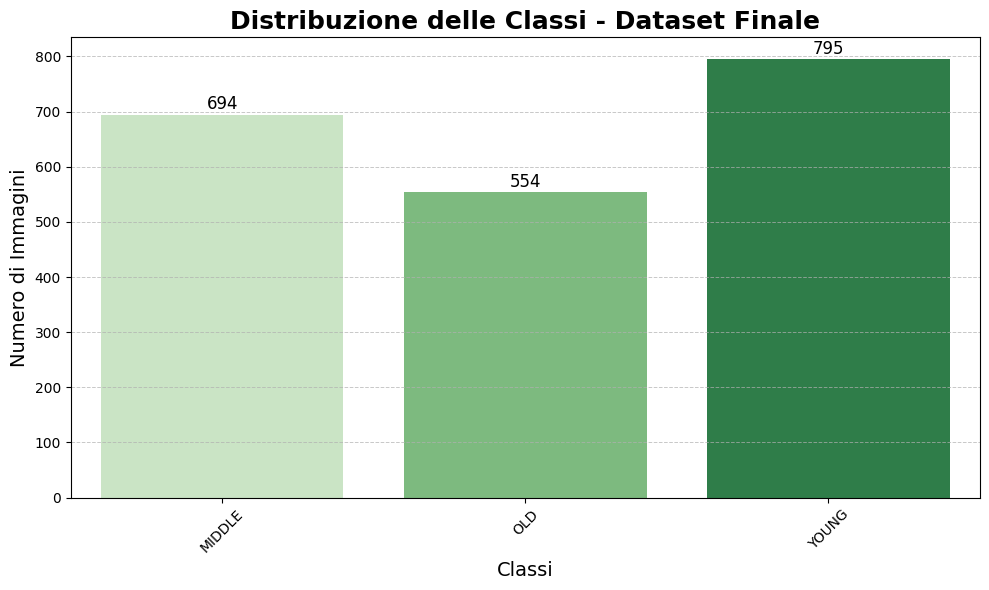

In [ ]:
filtered_annotations_file = "final_images/filtered_annotations.csv"
filtered_annotations = pd.read_csv(filtered_annotations_file)

class_distribution_final = filtered_annotations['Class'].value_counts().sort_index()

# Creare una figura per il grafico
fig, ax = plt.subplots(figsize=(10, 6))

# Colori per il plot
palette_final = sns.color_palette("Greens", len(class_distribution_final))

# Plot per il dataset finale
sns.barplot(
    x=class_distribution_final.index,
    y=class_distribution_final.values,
    palette=palette_final,
    ax=ax
)
ax.set_title('Distribuzione delle Classi - Dataset Finale', fontsize=18, fontweight='bold')
ax.set_xlabel('Classi', fontsize=14)
ax.set_ylabel('Numero di Immagini', fontsize=14)
ax.tick_params(axis='x', rotation=45)
ax.grid(axis='y', linestyle='--', linewidth=0.7, alpha=0.7)

# Annotazioni per mostrare i valori sulle barre
for i, value in enumerate(class_distribution_final.values):
    ax.text(i, value + 10, str(value), ha='center', fontsize=12, color='black')

# Migliora il layout per evitare sovrapposizioni
plt.tight_layout()

# Mostra il grafico finale
plt.show()


In the chart above, I visualised the class distribution of the final dataset after the application of the data augmentation step specifically targeting the old category. The bar plot effectively displays the number of images for each class along the x-axis, with the corresponding counts on the y-axis.

Here’s a breakdown:

Class Balancing Outcome:

- The $old$ class, which was previously underrepresented, has now increased to a count of 554 images, aligning more closely with the other categories.
- $middle$ and $young$ remain unaffected, with their original counts intact, ensuring that no overbalancing occurred.


---



This code below visually inspects the dataset by randomly sampling and displaying a fixed number of images (*num_images_per_class = 5*) for each class in a grid layout. It ensures that the images are correctly categorized and diverse after preprocessing and augmentation. Each row corresponds to a class, with titles indicating the class name. The clean layout (*plt.tight_layout()*) allows easy identification of patterns or anomalies.

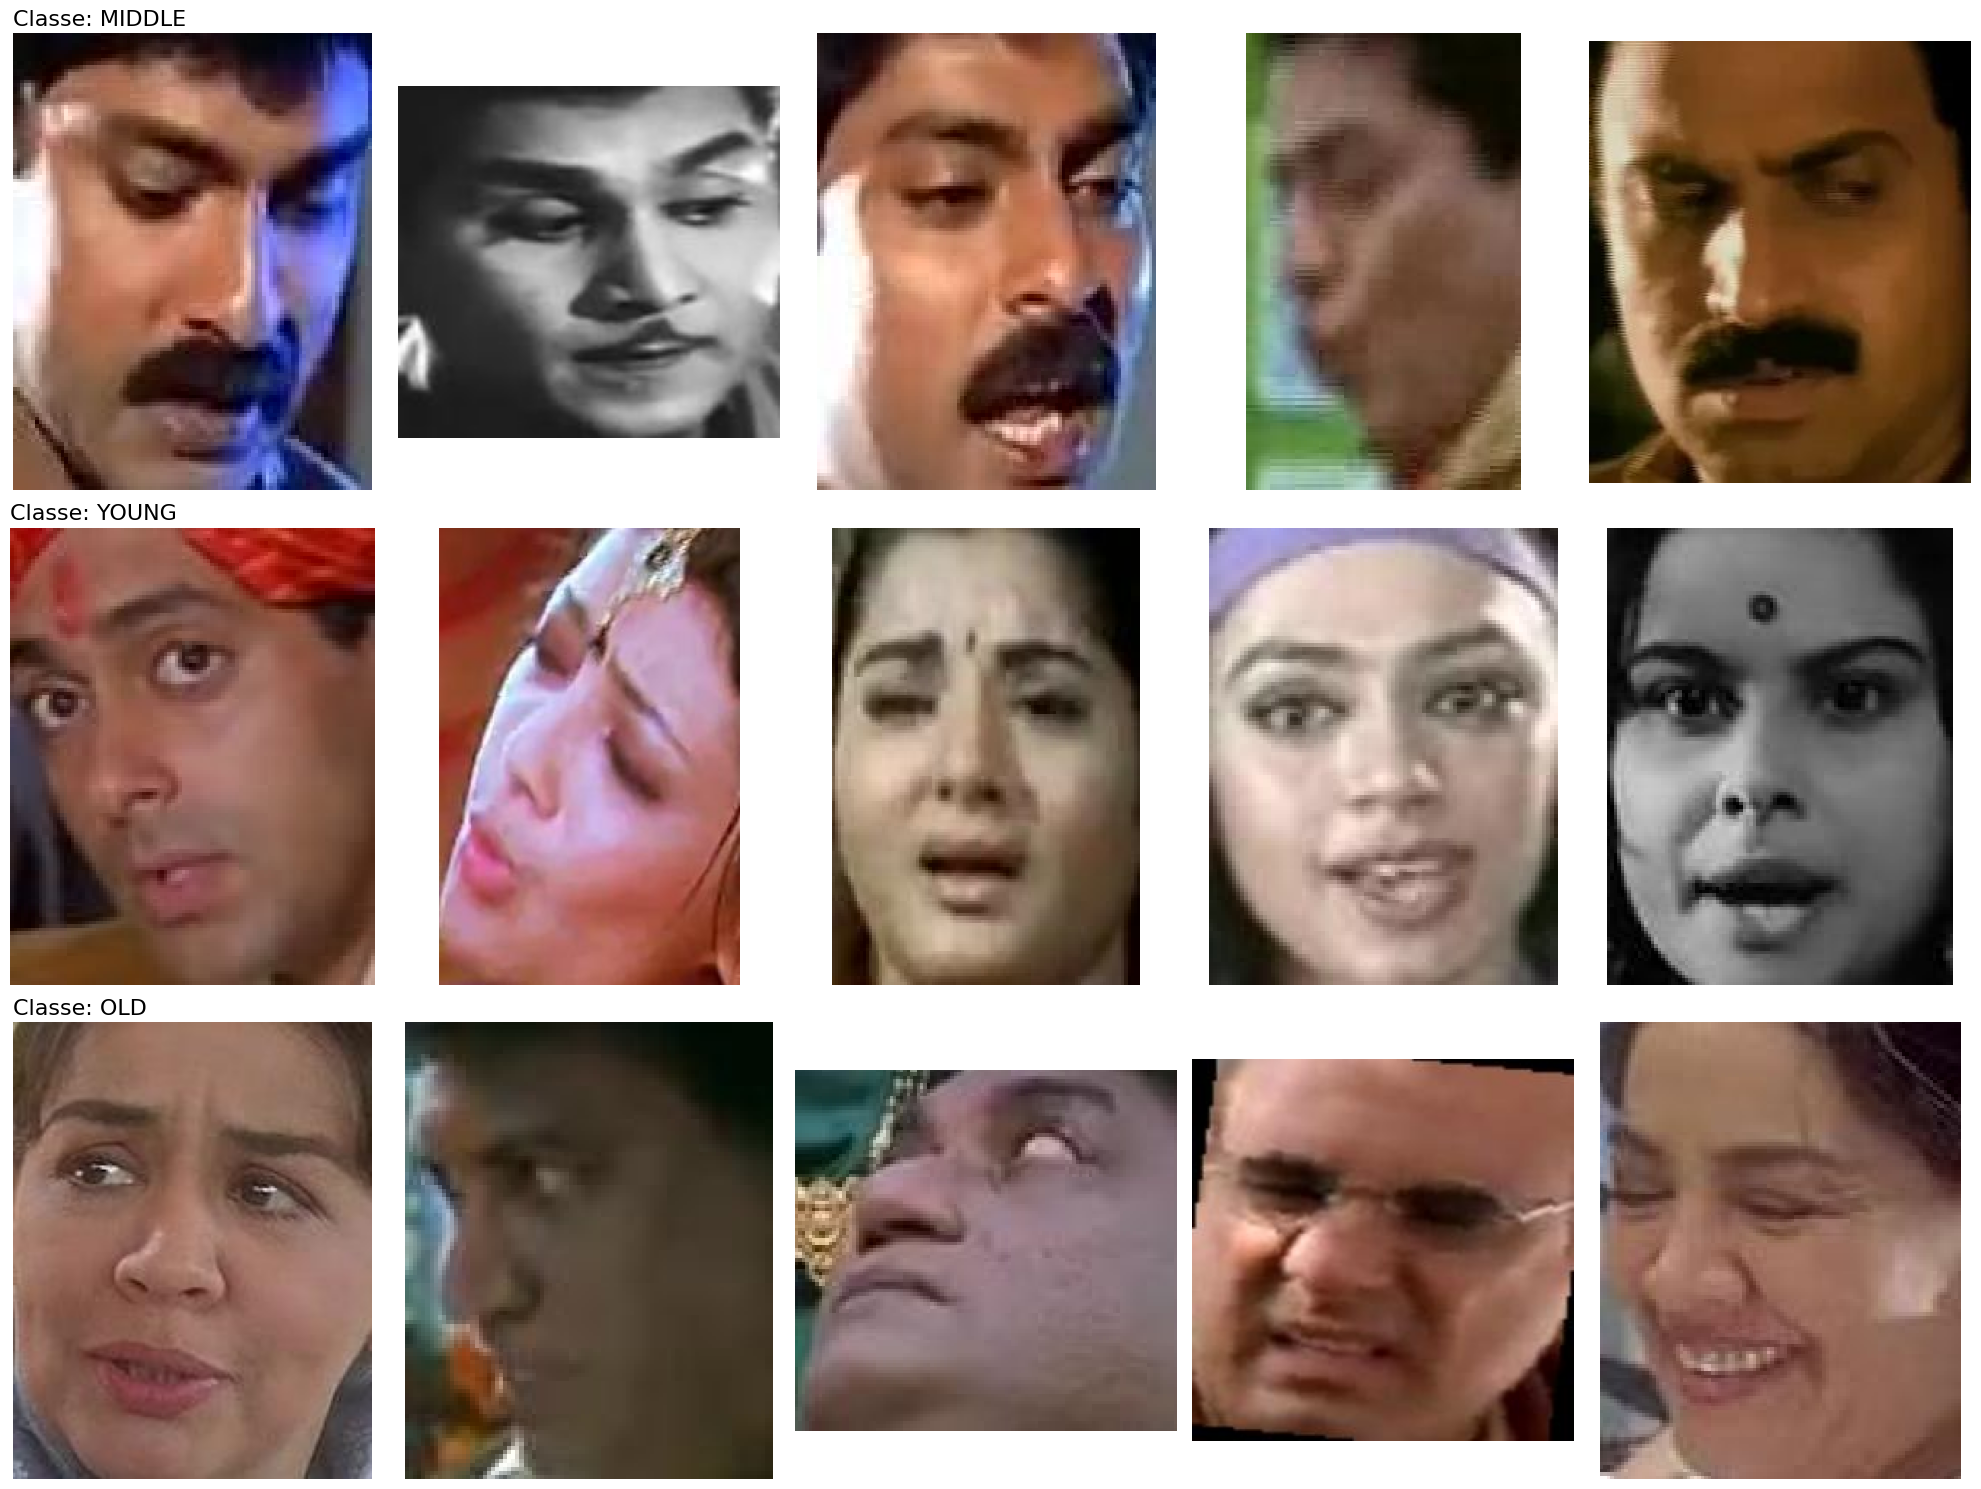

In [ ]:
balanced_annotations_file = "final_images/filtered_annotations.csv"
balanced_annotations = pd.read_csv(balanced_annotations_file)

output_dir = "final_images"

num_images_per_class = 5

# Ottenere le classi uniche
classes = balanced_annotations['Class'].unique()

# Creare una figura per mostrare le immagini
fig, axes = plt.subplots(len(classes), num_images_per_class, figsize=(20, 5 * len(classes)))

# Iterare su ogni classe
for class_idx, class_name in enumerate(classes):
    # Filtrare le annotazioni per la classe corrente
    class_images = balanced_annotations[balanced_annotations['Class'] == class_name]

    # Selezionare casualmente `num_images_per_class` immagini
    sampled_images = class_images.sample(num_images_per_class, random_state=42)['ID']

    # Mostrare ogni immagine in una riga della griglia
    for image_idx, img_name in enumerate(sampled_images):
        img_path = os.path.join(output_dir, img_name)
        img = Image.open(img_path)
        ax = axes[class_idx, image_idx]
        ax.imshow(img)
        ax.axis('off')
        if image_idx == 0:  # Aggiungere il titolo della classe alla prima immagine della riga
            ax.set_title(f"Classe: {class_name}", fontsize=16, loc='left')

plt.tight_layout()
plt.show()



To ensure consistency between the annotated dataset and the image files, this below script verifies that every image in the final_images directory is referenced in the filtered_annotations.csv file. It identifies and removes any extra images that are not listed in the annotations, ensuring that only valid images remain. The process concludes by counting the remaining images and comparing them with the annotation entries, providing feedback on whether the dataset is fully synchronized or if mismatches persist.

In [ ]:
final_images_dir = "final_images"
balanced_annotations_file = os.path.join(final_images_dir, "filtered_annotations.csv")

balanced_annotations = pd.read_csv(balanced_annotations_file)

# Ottienere la lista degli ID delle immagini dal file delle annotazioni
valid_image_ids = set(balanced_annotations['ID'])

# Contare le immagini presenti nella directory
all_images = [
    file for file in os.listdir(final_images_dir)
    if os.path.isfile(os.path.join(final_images_dir, file)) and file.lower().endswith(('.jpg', '.jpeg', '.png'))
]

# Eliminare le immagini che non sono nel file delle annotazioni bilanciate
images_removed = 0
for img_name in all_images:
    if img_name not in valid_image_ids:
        os.remove(os.path.join(final_images_dir, img_name))
        images_removed += 1

# Contare le immagini rimaste nella directory
remaining_images_count = len([
    file for file in os.listdir(final_images_dir)
    if os.path.isfile(os.path.join(final_images_dir, file)) and file.lower().endswith(('.jpg', '.jpeg', '.png'))
])

# Output del risultato
print(f"Numero di immagini rimosse: {images_removed}")
print(f"Numero di immagini rimaste nella directory: {remaining_images_count}")
print(f"Numero di annotazioni nel file bilanciato: {balanced_annotations.shape[0]}")

if remaining_images_count == balanced_annotations.shape[0]:
    print("✅ Tutte le immagini nella directory ora corrispondono alle annotazioni!")
else:
    print("❌ Ci sono ancora discrepanze tra le immagini e le annotazioni!")


Numero di immagini rimosse: 0
Numero di immagini rimaste nella directory: 2043
Numero di annotazioni nel file bilanciato: 2043
✅ Tutte le immagini nella directory ora corrispondono alle annotazioni!


The dataset is now ready to be used in the analysis 👍



---


### **Splitting the dataset**

The dataset, which has undergone previous preprocessing and augmentation, is now divided into three subsets: training (70%), validation (20%), and testing (10%). Using the *train_test_split* function from *sklearn*, the process ensures that proportionality between classes is maintained across the subsets.

In [ ]:
# Percorso del file delle annotazioni bilanciate
balanced_annotations_file = 'final_images/filtered_annotations.csv'

# Directory delle immagini finali
final_images_dir = 'final_images'

# Caricare il file delle annotazioni bilanciate
balanced_annotations = pd.read_csv(balanced_annotations_file)

# **1. Dividere il dataset in train (70%), temp (30%)**
train_df, temp_df = train_test_split(
    balanced_annotations,
    test_size=0.3,  # 30% per validation + test
    stratify=balanced_annotations['Class'],  # Stratifica per classe
    random_state=42
)

# **2. Dividere il temp (30%) in validation (20%) e test (10%)**
val_df, test_df = train_test_split(
    temp_df,
    test_size=0.33,  # 33% di temp -> 10% del totale
    stratify=temp_df['Class'],  # Stratifica per classe
    random_state=42
)

# Stampare la distribuzione delle classi
print("Distribuzione delle classi nei set:")
print("Training set:\n", train_df['Class'].value_counts())
print("Validation set:\n", val_df['Class'].value_counts())
print("Test set:\n", test_df['Class'].value_counts())

# **3. Creare directory per training, validation e test**
output_dirs = {
    'train': 'dataset/train',
    'validation': 'dataset/validation',
    'test': 'dataset/test'
}

for dir_path in output_dirs.values():
    os.makedirs(dir_path, exist_ok=True)

# **4. Spostare le immagini nei rispettivi set**
def move_images(df, target_dir):
    for _, row in df.iterrows():
        img_name = row['ID']
        src_path = os.path.join(final_images_dir, img_name)
        dest_path = os.path.join(target_dir, img_name)
        if os.path.exists(src_path):  # Controlla che il file esista
            shutil.copy(src_path, dest_path)

# Spostare le immagini
move_images(train_df, output_dirs['train'])
move_images(val_df, output_dirs['validation'])
move_images(test_df, output_dirs['test'])

# Salvare i file delle annotazioni per ciascun set
train_df.to_csv(os.path.join(output_dirs['train'], 'annotations_train.csv'), index=False)
val_df.to_csv(os.path.join(output_dirs['validation'], 'annotations_validation.csv'), index=False)
test_df.to_csv(os.path.join(output_dirs['test'], 'annotations_test.csv'), index=False)

print("Divisione completata. I file sono stati salvati nelle directory dei rispettivi set.")


Distribuzione delle classi nei set:
Training set:
 Class
YOUNG     556
MIDDLE    486
OLD       388
Name: count, dtype: int64
Validation set:
 Class
YOUNG     160
MIDDLE    139
OLD       111
Name: count, dtype: int64
Test set:
 Class
YOUNG     79
MIDDLE    69
OLD       55
Name: count, dtype: int64
Divisione completata. I file sono stati salvati nelle directory dei rispettivi set.


After splitting, the class distribution across the three subsets is printed for verification. The resulting distribution is as follows:
- Training Set: YOUNG (556), MIDDLE (486), OLD (388)
- Validation Set: YOUNG (160), MIDDLE (139), OLD (111)
- Test Set: YOUNG (79), MIDDLE (69), OLD (55)



---



# **Fine-Tuning Vision Transformer (ViT) for Age Classification**

For this stage of the project, I leveraged the **Vision Transformer** (ViT) model, specifically the pre-trained *google/vit-base-patch16-224*, to adapt it for the task of age classification. The model has been fine-tuned to classify images into my three categories. Here's an overview of the key characteristics and advantages of this model:

The Vision Transformer (ViT) is an architecture that applies the transformer mechanism, originally developed for natural language processing, to computer vision tasks. Unlike convolutional neural networks (CNNs), ViT operates on sequences of image patches rather than pixels, enabling it to model long-range dependencies more effectively.

Key Features of ViT:
- **Patch-Based Representatio**n:
 Instead of processing an entire image directly, ViT divides the input image into fixed-size patches (e.g., 16×16 pixels for *vit-base-patch16-224*) and flattens them into vectors.
These patches are then linearly projected into a lower-dimensional embedding space.

- **Self-Attention Mechanism**:
ViT uses the self-attention mechanism from transformers to capture relationships between image patches. This mechanism allows the model to focus on relevant regions of the image for the classification task.

- **Pretrained on Large Datasets**:
The *google/vit-base-patch16-224* model is pretrained on large-scale datasets like ImageNet. This pretraining ensures the model has already learned rich, generalized visual features, which can be fine-tuned for specific downstream tasks like age classification.

- **Classification Token**:
ViT introduces a special learnable token, called the CLS token, which aggregates the information from all patches. The final classification head processes this token to make predictions.

- **Positional Encoding**:
Since transformers do not inherently understand the spatial arrangement of patches, ViT incorporates positional encoding to provide spatial context to each patch. This encoding allows the model to maintain an awareness of where each patch is located in the original image.

- **Gradient Descent and Optimization**:
During pretraining, the model's weights were optimized using advanced variants of gradient descent, such as the Adam optimizer. These optimization techniques ensure efficient learning of complex patterns in large-scale datasets.

- **Cross Entropy Loss**:
The ViT was trained using the cross entropy loss function, which evaluates the difference between predicted and actual class probabilities.

- **Dropout for Regularization**:
To prevent overfitting during pretraining, dropout was applied in various layers. This randomly "drops" a percentage of neurons during training, enhancing the model's ability to generalize.

- **Automatic Differentiation and Backpropagation**:
The pretraining of ViT utilized automatic differentiation to compute gradients of the loss function with respect to the model parameters. These gradients were then propagated backward through the network during optimization.

- **Scalability and Efficiency**:
The transformer architecture scales effectively with model size, making ViT capable of leveraging massive datasets and achieving state-of-the-art performance.

For additional information one may read the official Hugging Face page at the following link:[google/vit-base-patch16-224](https://huggingface.co/google/vit-base-patch16-224)

Let's now analyse the code:

To prevent the occurrence of a request for an authentication API key to wandb we wrote this line of code:

In [ ]:
# Disabilitiamo Weights & Biases (W&B)
os.environ["WANDB_MODE"] = "disabled"

Let's commence the preparation of the data. This custom dataset class is a tailored PyTorch Dataset designed to prepare data for the age classification model. It reads annotations from a CSV file and maps each image ID to its corresponding class label

In [ ]:
# Dataset personalizzato
class CustomImageDataset(Dataset):                                   # CustomImageDataset è un implementazione di pytorch dataset class per caricare dataset di age classification
    def __init__(self, annotations_file, img_dir, transform=None):
        self.annotations = pd.read_csv(annotations_file)             # annotazioni
        self.img_dir = img_dir                                       # directory per le immagini
        self.transform = transform                                   # trasformazioni opzionali che vengono applicate a ciascuna immagine (tipo normalization)
        self.label_map = {"YOUNG": 0, "MIDDLE": 1, "OLD": 2}         # è necessario convertire le variabili categorieche in formato numerico

    def __len__(self):
        return int(len(self.annotations) * 0.2)                      # riduco al 20% del dataset

    def __getitem__(self, idx):                                      # con questo metodo si ottiene un single sample (ovvero un immagine con il corrispettivo lable)
        img_name = self.annotations.iloc[idx, 0]
        label = self.annotations.iloc[idx, 1]

        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert("RGB")                  # si convere l'immagine in formato RGB

        if self.transform:
            image = self.transform(image)                            # eventuale trasformazione dell'immagine

        label = self.label_map[label]
        return {"pixel_values": image, "label": label}               # si ottiene un dizionario con l'immagine trasformata (tensor) e con value c'è il valore numerico del label

The preprocessing step prepares the raw images for compatibility with the Vision Transformer (ViT) model. Key operations include resizing all images to 224x224 pixels, converting them into PyTorch tensors, and normalizing them based on the mean and standard deviation used during the ViT model's training

In [ ]:
# Preprocessamento
image_processor = AutoImageProcessor.from_pretrained("google/vit-base-patch16-224")  # load del modello pre addestrato
transform = Compose([   # la funzione compose di torchvision.transforms applica una serie di trasformazioni alle immagini
    Resize((224, 224)), # è la dimensione ch eil vit si apsetta di ricevere
    ToTensor(),         # ci converte l'immagine da PIL (ovvero numpy array) in un pytorch tensor con i valori dei pixel normalizzati (tra 0 e 1)
    Normalize(mean=image_processor.image_mean, std=image_processor.image_std),
])

This block initializes datasets for training, validation, and testing using the previously defined *CustomImageDataset* class.

In [ ]:
# Dataset
data_dir = "dataset"
train_dataset = CustomImageDataset(
    annotations_file=os.path.join(data_dir, "train", "annotations_train.csv"),
    img_dir=os.path.join(data_dir, "train"),
    transform=transform,
)

val_dataset = CustomImageDataset(
    annotations_file=os.path.join(data_dir, "validation", "annotations_validation.csv"),
    img_dir=os.path.join(data_dir, "validation"),
    transform=transform,
)

test_dataset = CustomImageDataset(
    annotations_file=os.path.join(data_dir, "test", "annotations_test.csv"),
    img_dir=os.path.join(data_dir, "test"),
    transform=transform,
)

To tailor the ViT to my task, I replaced its pre-trained classification head with a new output layer configured for three classes. Using *ignore_mismatched_sizes=True*, I ensured seamless adaptation of the model architecture.

In [ ]:
# Modello
model = AutoModelForImageClassification.from_pretrained(  # questo modello utilizza in automatico la cross entropy loss
    "google/vit-base-patch16-224",
    num_labels=3,  # numero di classi
    ignore_mismatched_sizes=True  # ignora il mismatch tra il layer pre-addestrato e il nuovo task
)

This next block specifies the training parameters and configurations using the *TrainingArguments* class from the transformers library. These arguments control aspects like evaluation frequency, model saving, batch size, and learning rate.

In [ ]:
# Parametri di addestramento ottimizzati
training_args = TrainingArguments(
    output_dir="./results",         # directory dove verrà salvato
    evaluation_strategy="epoch",    # modello valutato alla fine di ogni epoca
    save_strategy="epoch",
    logging_dir="./logs",
    logging_steps=10,
    per_device_train_batch_size=32,  # batch size
    per_device_eval_batch_size=32,
    num_train_epochs=2,              # due epoce di addestramento
    learning_rate=5e-5,
    load_best_model_at_end=True,
)

To train the model efficiently, I utilized the *Trainer* class from the transformers library. The *Trainer* combines:

- The Vision Transformer (ViT) model for image classification.
- The datasets for training and validation.
- The optimized training arguments, including batch size, learning rate, and evaluation frequency.

The Trainer automates the training loop, periodic evaluations, and logging, significantly simplifying the workflow. This approach ensures consistency, reduces potential errors, and accelerates the training process while maintaining high customizability.

In [ ]:
# Trainer
trainer = Trainer(
    model=model,                  # modello pre addestrato
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=image_processor,
)

The training phase is initiated using the* trainer.train()* method. This process fine-tunes the pre-trained Vision Transformer on my custom dataset.

In [ ]:
# Addestramento
trainer.train()

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([3]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([3, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-17-cff8ce4d95ac>:78: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
wandb: WARNING The `run_name` is currently set to t

Epoch,Training Loss,Validation Loss
1,No log,0.662496
2,0.900300,0.605682


TrainOutput(global_step=18, training_loss=0.7001560396618314, metrics={'train_runtime': 925.5199, 'train_samples_per_second': 0.618, 'train_steps_per_second': 0.019, 'total_flos': 4.432581533424845e+16, 'train_loss': 0.7001560396618314, 'epoch': 2.0})

The training process was monitored across two key metrics: ** Training Loss** and **Validation Loss**. These metrics provide valuable insight into the model's learning and generalization capabilities:

**Training Loss** quantifies how well the model fits the training data. A lower value indicates that the model predictions are closely aligned with the true labels in the training set. However, an excessively low training loss might suggest overfitting.

**Validation Loss** measures the model's performance on unseen validation data, helping assess its generalization. A consistent decrease in validation loss is a strong indicator of effective learning, while an increase could signal overfitting.

Let's now obtain a graphical representation of the results obtained

              precision    recall  f1-score   support

       YOUNG       0.67      0.60      0.63        10
      MIDDLE       0.63      0.80      0.71        15
         OLD       0.92      0.73      0.81        15

    accuracy                           0.72        40
   macro avg       0.74      0.71      0.72        40
weighted avg       0.75      0.72      0.73        40



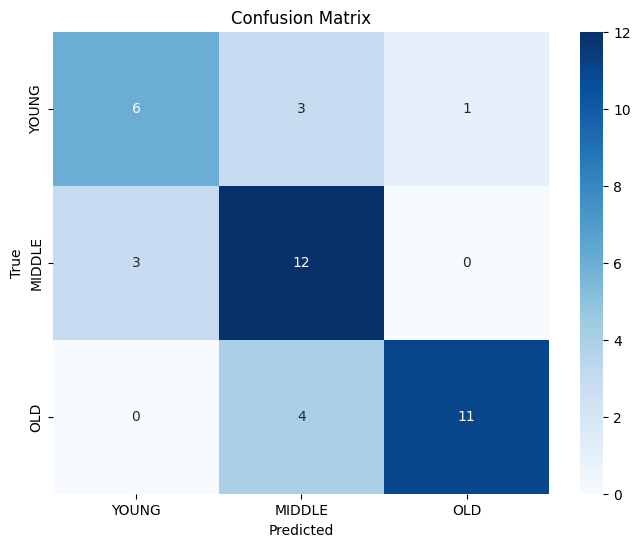

In [ ]:
# predizioni e le etichette corrispondenti
predictions = trainer.predict(test_dataset)

# Predizioni
y_pred = predictions.predictions.argmax(axis=1)

# Etichette vere corrispondenti alle predizioni
y_true = predictions.label_ids

# report di classificazione
print(classification_report(y_true, y_pred, target_names=["YOUNG", "MIDDLE", "OLD"]))

conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d",
            xticklabels=["YOUNG", "MIDDLE", "OLD"],
            yticklabels=["YOUNG", "MIDDLE", "OLD"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


The classification report provides a summary of the model's performance across three age groups using key metrics:

- **Precision**: This measures the proportion of true positives among all predictions made for a particular class. High precision indicates fewer false positives.
- **Recall**: This evaluates the model's ability to correctly identify all instances of a given class, reflecting sensitivity to false negatives.
- **F1-Score**: This is the harmonic mean of precision and recall, providing a balanced view of the model's performance for imbalanced datasets.
- **Support**: The number of true instances of each class in the dataset, highlighting class distribution.

The confusion matrix complements the report by showing the true versus predicted class distributions, offering a direct view of misclassifications. Each cell quantifies the number of samples predicted as a certain class while belonging to another.

The model demonstrates varied performance across the three classes. Certain classes, like old,  achieve better precision but may struggle slightly with recall, indicating it predicts fewer false positives while missing some true instances.
The confusion matrix confirms a higher degree of misclassification between adjacent age categories like young and middle, which is expected due to overlapping features (e.g., facial similarities between young and middle-aged individuals).
The overall accuracy of the model suggests reasonable performance

This code below allows me to compare predictions from two models trained at different epochs (first and second) on a single image uploaded by the user. It provides a clear demonstration of how the model's performance changes and evolves during training by analyzing its predictions at different stages.

In [ ]:
# pesi della prima epoca
first_epoch_checkpoint = "./results/checkpoint-12"  # Modifica con il percorso corretto
model_first_epoch = AutoModelForImageClassification.from_pretrained(first_epoch_checkpoint)

# pesi della seconda epoca
second_epoch_checkpoint = "./results/checkpoint-24"  # Modifica con il percorso corretto
model_second_epoch = AutoModelForImageClassification.from_pretrained(second_epoch_checkpoint)

#  processore delle immagini
image_processor = AutoImageProcessor.from_pretrained("google/vit-base-patch16-224")

# un'immagine dal PC
from google.colab import files

print("Carica un'immagine dal tuo PC:")
uploaded = files.upload()  # Permette di caricare un'immagine dal PC
image_path = next(iter(uploaded))  # Ottieni il percorso del file caricato

# Preprocessamento dell'immagine
image = Image.open(image_path).convert("RGB")
inputs = image_processor(images=image, return_tensors="pt")

# Predizioni con il modello della prima epoca
model_first_epoch.eval()
with torch.no_grad():
    outputs_first_epoch = model_first_epoch(**inputs)
    predicted_class_first_epoch = torch.argmax(outputs_first_epoch.logits, dim=1).item()

# Predizioni con il modello della seconda epoca
model_second_epoch.eval()
with torch.no_grad():
    outputs_second_epoch = model_second_epoch(**inputs)
    predicted_class_second_epoch = torch.argmax(outputs_second_epoch.logits, dim=1).item()

# Mappa delle classi
class_labels = ["YOUNG", "MIDDLE", "OLD"]

# Stampa dei risultati
print(f"Predizione con il modello della prima epoca: {class_labels[predicted_class_first_epoch]}")
print(f"Predizione con il modello della seconda epoca: {class_labels[predicted_class_second_epoch]}")



Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


Carica un'immagine dal tuo PC:


Saving Fototessera.jpeg to Fototessera.jpeg
Predizione con il modello della prima epoca: YOUNG
Predizione con il modello della seconda epoca: YOUNG


The prediction is correct.



---



# **Leveraging AlexNet for Age Classification**

AlexNet is one of the foundational architectures in the field of deep learning for image classification. Initially introduced in 2012, it revolutionized the domain by using deep convolutional neural networks trained on large datasets such as ImageNet. The architecture comprises five convolutional layers followed by three fully connected layers. Key features include the use of ReLU activations, dropout for regularization, and max-pooling to reduce dimensionality.

In this implementation, I have fine-tuned AlexNet, pre-trained on the ImageNet dataset, for the task of age classification into my three categories. To adapt AlexNet to this specific task, I replaced its final fully connected layer with a new one tailored for three classes, while retaining the learned weights from ImageNet for feature extraction. This approach leverages the rich features learned during pre-training, ensuring robust performance on a relatively smaller age classification dataset.

Let's begin analysing the code.

This segment initializes key hyperparameters and configurations for training the model. It specifies the computational device (*torch.device*), the number of output classes (*num_classes*), batch size (*batch_size*), learning rate (*learning_rate*), and the maximum epochs (*num_epochs*). Additionally, it introduces an early stopping mechanism with a patience of 2 epochs, ensuring that training halts automatically if no improvement is observed in the validation loss for consecutive epochs, effectively preventing overfitting and optimizing training efficiency.

In [ ]:
# **1. Configurazione**
device = torch.device("cpu")  # Usa la CPU, se volessi usare la GPU allora metto cuda
num_classes = 3               # 3 classi
batch_size = 32
learning_rate = 1e-4
num_epochs = 2                # Numero massimo di epoche
patience = 2                  # Early stopping: ferma l'addestramento dopo 2 epoche senza miglioramenti


This *CustomDataset* class prepares and loads image data for training and validation, as done previously.

In [ ]:
# 2. Dataset personalizzato
class CustomDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None):
        self.annotations = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.label_map = {"YOUNG": 0, "MIDDLE": 1, "OLD": 2}

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        img_name = self.annotations.iloc[idx, 0]
        label = self.annotations.iloc[idx, 1]
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        label = self.label_map[label]
        return image, label


This preprocessing pipeline ensures that input images are compatible with AlexNet by resizing them to 224x224 and applying standard normalization based on ImageNet statistics. While conceptually similar to the ViT preprocessing, the use of fixed normalization values instead of dynamic ones tailored to ViT reflects the differences in these models' requirements.

In [ ]:
# 3. Preprocessamento
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Dimensioni richieste da AlexNet
    transforms.ToTensor(),          # si converte le immagini in pytorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # la media corrisponde all'intensità media dei colori del rosso, verde e blu presenti in ImageNe mentre la deviazione standard assicura che ogni channel ha un unit variance dopo essere stato normalizzato.
])

Loading the data

In [ ]:
# 4. Caricamento dei dataset
data_dir = "dataset"
train_dataset = CustomDataset(
    annotations_file=os.path.join(data_dir, "train", "annotations_train.csv"),
    img_dir=os.path.join(data_dir, "train"),
    transform=transform,
)
val_dataset = CustomDataset(
    annotations_file=os.path.join(data_dir, "validation", "annotations_validation.csv"),
    img_dir=os.path.join(data_dir, "validation"),
    transform=transform,
)
test_dataset = CustomDataset(
    annotations_file=os.path.join(data_dir, "test", "annotations_test.csv"),
    img_dir=os.path.join(data_dir, "test"),
    transform=transform,
)

These lines below prepare iterable data loaders for the training, validation, and test datasets.I used  shuffling for training data and disabling it for validation/testing.

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

This step initializes the AlexNet architecture, leveraging its pre-trained weights on ImageNet for transfer learning. By replacing the final classification layer with one suited to our task (3 output classes), I fine-tune AlexNet to classify images into YOUNG, MIDDLE, or OLD.

In [ ]:
# 5. Carica AlexNet pre-addestrato
model = models.alexnet(pretrained=True)  # Modello pre-addestrato su ImageNet
model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)   # alexnet fully connected layer ha un output di 1000 classi  quindi sostituisco questo layer con un altro fully connected layer (nn.linear) per le mie tre classi
model = model.to(device)

This section defines the criterion (loss function) and the optimizer, which are core to the training process, ensuring the model improves its predictions with each epoch.

**Loss Function: CrossEntropyLoss**

 The *CrossEntropyLoss* function is specifically designed for multi-class classification tasks. It works by combining two critical steps:

1. **Log Softmax**:
Converts raw model outputs (logits) into probabilities, ensuring they sum to 1 across all classes.

2. **Negative Log Likelihood**:
Penalizes predictions that assign low probabilities to the correct class, pushing the model to predict higher confidence values for the correct labels.
Mathematically:

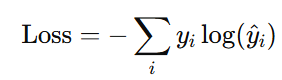


This function outputs a scalar loss value that represents how far the model's predictions are from the true labels. A lower loss indicates better alignment between predictions and actual labels.

**Optimizer: Adam**

The Adam optimizer (Adaptive Moment Estimation) combines the benefits of:

1. **Momentum**:
Uses a moving average of past gradients to smooth updates, avoiding oscillations in the learning process.

2. **RMSprop**:
Scales updates based on recent gradient magnitudes, adapting the learning rate for each parameter dynamically.

Adam includes two key components:

- **Learning Rate (
𝛼
)**:
Controls the step size of weight updates. It ensures adjustments are neither too aggressive nor too slow.

- **Beta Parameters**:
Decay rates for the moment estimates, balancing sensitivity to gradient directions.

Mathematically:

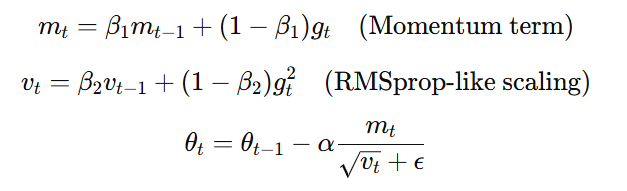

This combination makes Adam highly efficient, requiring little manual tuning and performing well across a wide variety of tasks.

For this multi-class age classification problem, CrossEntropyLoss ensures the model focuses on improving its probability estimates for the correct class. Meanwhile, the Adam optimizer dynamically adjusts learning rates for each parameter, making training both efficient and robust.

In [ ]:
#6. Funzione di perdita e ottimizzatore
criterion = nn.CrossEntropyLoss()                       # è la losso function usata per multi-class classification
optimizer = Adam(model.parameters(), lr=learning_rate)

The EarlyStopping mechanism monitors the validation loss during training and halts the process if no improvement is observed for a predefined number of consecutive epochs (patience). It ensures computational efficiency and prevents overfitting by saving the best-performing model's weights. If the validation loss improves, the counter resets, and the model's state is saved. Otherwise, the counter increments, and training stops once the patience threshold is reached. This approach is critical for optimizing training resources while maintaining model performance.

In [ ]:
# 7. Early Stopping
class EarlyStopping:
    def __init__(self, patience=2, verbose=False, path="best_model.pth"):
        self.patience = patience
        self.verbose = verbose   # info sullo stato dell'early stopping
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.path = path

    def __call__(self, val_loss, model):   # si confronta la perdita attuale (val loss) con la migliore perdita osservata (best loss)
        if self.best_loss is None or val_loss < self.best_loss:
            self.best_loss = val_loss
            self.counter = 0
            torch.save(model.state_dict(), self.path)
            if self.verbose:
                print(f"✔️ Modello migliorato, salvato in {self.path}")
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
                if self.verbose:
                    print("⚠️ Early stopping attivato")

The train_model function orchestrates the training process, combining standard model training with early stopping to optimize performance and efficiency. For each epoch, the model alternates between training and validation phases. During training, the optimizer minimizes the loss function by updating model weights via backpropagation. Validation evaluates the model on unseen data, computing the average loss to monitor overfitting. Early stopping halts training if validation loss doesn't improve within a set number of epochs (patience), ensuring the best model state is preserved. This approach minimizes overfitting and computational overhead while maintaining generalization capabilities.








In [ ]:
#8. Addestramento
def train_model(model, train_loader, val_loader, num_epochs, patience):
    early_stopping = EarlyStopping(patience=patience, verbose=True)
    start_time = time.time()

    for epoch in range(num_epochs):
        print(f"Epoca {epoch+1}/{num_epochs}")

        # Modalità di training
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        train_loss = running_loss / len(train_loader)
        print(f"Loss di training: {train_loss:.4f}")

        # Modalità di validazione
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        val_loss /= len(val_loader)
        print(f"Loss di validazione: {val_loss:.4f}")

        # Early stopping
        early_stopping(val_loss, model)
        if early_stopping.early_stop:
            print("Early stopping attivato")
            break

    total_time = time.time() - start_time
    print(f"Tempo totale di addestramento: {total_time:.2f} secondi")

    # miglior modello
    model.load_state_dict(torch.load(early_stopping.path))
    return model

In [ ]:
# Addestramento
model = train_model(model, train_loader, val_loader, num_epochs=num_epochs, patience=patience)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 226MB/s]


Epoca 1/2
Loss di training: 0.8519
Loss di validazione: 0.6393
✔️ Modello migliorato, salvato in best_model.pth
Epoca 2/2
Loss di training: 0.4440
Loss di validazione: 0.5170
✔️ Modello migliorato, salvato in best_model.pth
Tempo totale di addestramento: 258.26 secondi


<ipython-input-20-39826040c714>:153: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(early_stopping.path))


The training process resulted in a noticeable decrease in both training and validation losses across the two epochs, indicating effective learning by the model.


Next I focused on the model's performance on the test set by computing key classification metrics, including precision, recall, and F1-score for each class. The model is set to evaluation mode using *model.eval()* to ensure no gradients are calculated during inference, enhancing efficiency. Predictions are obtained by selecting the class with the highest output logits (*torch.max*), and the results are compared with ground truth labels. Finally, the *classification_report* function from *sklearn* provides a detailed performance breakdown, highlighting the model's strong overall accuracy and balanced performance across classes.

In [ ]:
# 9. Valutazione sul test set
def evaluate_model(model, test_loader):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    # report di classificazione
    print("\nReport di classificazione:")
    print(classification_report(y_true, y_pred, target_names=["YOUNG", "MIDDLE", "OLD"]))

# Valutare il modello
evaluate_model(model, test_loader)


Report di classificazione:
              precision    recall  f1-score   support

       YOUNG       0.88      0.87      0.88        79
      MIDDLE       0.84      0.81      0.82        69
         OLD       0.88      0.93      0.90        55

    accuracy                           0.87       203
   macro avg       0.87      0.87      0.87       203
weighted avg       0.87      0.87      0.87       203



Let's now have a visual rappresentation of the model performance:

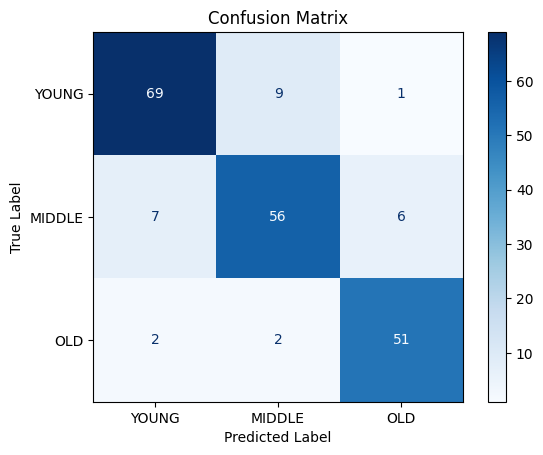

In [ ]:
# Predizioni e etichette vere (dai risultati del modello)
y_true = []  # Etichette vere
y_pred = []  # Predizioni del modello

# Ottieni predizioni sul test set
model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# Classi del dataset
class_names = ["YOUNG", "MIDDLE", "OLD"]

# Calcola la confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Visualizza la confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.grid(False)
plt.show()


The confusion matrix illustrates the model's ability to correctly classify samples for each age group.

- Diagonal values represent correct classifications, showing the number of samples accurately predicted. The high diagonal values reflect strong model performance overall.
- Off-diagonal values highlight misclassifications. For example, a small portion of middle instances was incorrectly classified as ypung or old. These misclassifications are likely due to overlapping features between classes, particularly middle and the other age groups.

The matrix confirms that the model has achieved balanced and reliable predictions, with minimal errors, particularly for the old class, which initially suffered from data imbalance.

Below I decided to evaluate the model's performance at a class-specific level for both validation and test datasets. The function *evaluate_by_class* calculates accuracy and average loss for each class.

- Accuracy Per Class: It computes the percentage of correct predictions per class by tracking correctly predicted samples (*class_correct*) against the total samples (*class_total*) for each class.
- Average Loss Per Class: It averages the loss values for each class by summing the loss (class_loss) across all samples of a class and dividing by the class's total number of samples.

In [ ]:
def evaluate_by_class(model, data_loader, criterion, class_names):
    model.eval()
    class_correct = np.zeros(len(class_names))
    class_total = np.zeros(len(class_names))
    class_loss = np.zeros(len(class_names))

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Calcolo della loss per ciascuna classe
            for i in range(len(labels)):
                class_loss[labels[i].item()] += loss.item()

            # Predizioni
            _, preds = torch.max(outputs, 1)
            for i in range(len(labels)):
                class_total[labels[i].item()] += 1
                if preds[i] == labels[i]:
                    class_correct[labels[i].item()] += 1

    # Calcolo delle metriche
    accuracy_per_class = class_correct / class_total
    average_loss_per_class = class_loss / class_total

    # Stampa delle metriche
    print("\nValutazione per classe:")
    for i, class_name in enumerate(class_names):
        print(f"Classe {class_name}:")
        print(f"  Accuracy: {accuracy_per_class[i] * 100:.2f}%")
        print(f"  Average Loss: {average_loss_per_class[i]:.4f}")

# Classi del dataset
class_names = ["YOUNG", "MIDDLE", "OLD"]

# Valutazione sul validation set
print("\nValidazione:")
evaluate_by_class(model, val_loader, criterion, class_names)

# Valutazione sul test set
print("\nTest:")
evaluate_by_class(model, test_loader, criterion, class_names)



Validazione:

Valutazione per classe:
Classe YOUNG:
  Accuracy: 75.00%
  Average Loss: 0.5176
Classe MIDDLE:
  Accuracy: 84.89%
  Average Loss: 0.5062
Classe OLD:
  Accuracy: 79.28%
  Average Loss: 0.5090

Test:

Valutazione per classe:
Classe YOUNG:
  Accuracy: 87.34%
  Average Loss: 0.3827
Classe MIDDLE:
  Accuracy: 81.16%
  Average Loss: 0.3896
Classe OLD:
  Accuracy: 92.73%
  Average Loss: 0.3875


The class-specific evaluation reveals interesting insights:

- Validation Set: Performance varies significantly across classes, with middle achieving the highest accuracy and the lowest loss. young shows room for improvement, possibly due to overlapping features with other classes or data scarcity.
- Test Set: Accuracy improves across all classes compared to validation, indicating better generalization. Notably, old achieves the highest accuracy and lowest loss, suggesting that data augmentation may have effectively addressed prior class imbalance.

These results emphasize the importance of class-level evaluation for identifying biases or weaknesses in the model's predictions.

Finally, I set out to try to see how the model predicts an image loaded from the pc. In this case the prediction turns out to be correct

In [ ]:
# modello salvato
model_path = "best_model.pth"

#  modello addestrato
model = models.alexnet(pretrained=False)                                       # Creare un'istanza di AlexNet
model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)  # Adattare l'output
model.load_state_dict(torch.load(model_path, map_location=device))             # Caricare i pesi salvati
model = model.to(device)
model.eval()                                                                   # modalità valutazione

# Trasformazioni per il preprocessing delle immagini
transform = Compose([
    Resize((224, 224)),  # Dimensioni richieste da AlexNet
    ToTensor(),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Classi
class_names = ["YOUNG", "MIDDLE", "OLD"]

# Funzione per caricare e predire
def predict_image(image_path):
    # Carica e preprocessa l'immagine
    image = Image.open(image_path).convert("RGB")
    input_tensor = transform(image).unsqueeze(0).to(device)  # dimensione batch

    # predizioni dal modello
    with torch.no_grad():
        outputs = model(input_tensor)
        _, predicted_class = torch.max(outputs, 1)  # Classe con probabilità massima

    # classe predetta
    return class_names[predicted_class.item()]

# immagine dal PC
from google.colab import files

uploaded = files.upload()
for image_name in uploaded.keys():
    image_path = image_name
    prediction = predict_image(image_path)
    print(f"L'immagine '{image_name}' è stata classificata come: {prediction}")


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
<ipython-input-86-9a07271a5ed9>:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the function

Saving Fototessera.jpeg to Fototessera (2).jpeg
L'immagine 'Fototessera (2).jpeg' è stata classificata come: YOUNG


## **Comparison between models**

In this study, I utilized two pretrained models—Vision Transformer (ViT) and AlexNet—to classify facial images into three age groups. Each model was fine-tuned on the same dataset under comparable settings, but the final results revealed notable differences in their performance. Below is a detailed comparison and analysis of the potential reasons behind the observed discrepancies.




**Architectural Differences**
- **ViT** is based on a transformer architecture, which excels at capturing global dependencies and relationships across the entire image. It processes input as a sequence of patches, leveraging self-attention mechanisms to capture long-range contextual features. This makes it particularly effective for high-resolution images with complex patterns.

- **AlexNet**, on the other hand, is a convolutional neural network (CNN) that uses hierarchical feature extraction through convolutional layers. While efficient for spatially localized patterns, its limited receptive field may struggle with subtle global relationships, especially in cases where age differences are reflected in less localized features like skin texture or wrinkles.

**Performance Differences**

1. Accuracy and Class-Level Performance:

   - ViT demonstrated more balanced performance across all classes, handling even the underrepresented "OLD" category reasonably well. Its ability to capture subtle age-related patterns likely contributed to better generalization, especially for challenging cases.

   - AlexNet, while achieving strong results overall, showed a slightly higher accuracy for "YOUNG" and "OLD" but struggled more with the "MIDDLE" class. This could be due to its reliance on local features, making it harder to distinguish between overlapping characteristics present in "MIDDLE" images.

2. Loss and Generalization:

   - ViT achieved lower validation and test losses, indicating better generalization. Its advanced architecture likely contributed to a smoother loss landscape, helping it converge more effectively.

   - AlexNet, while showing respectable loss values, may have faced challenges in learning complex relationships due to its relatively older and less sophisticated design. This could explain the slightly higher loss values and potential overfitting tendencies.


**Data and Preprocessing Impact**

Both models were trained on the same dataset, but their performance differences may also stem from:

- Input Size and Preprocessing Requirements:

   - ViT requires input as a sequence of patches and benefits from higher resolution, allowing it to capture detailed patterns. The preprocessing pipeline optimized for ViT may have enhanced its performance.

   - AlexNet, while robust, is designed for simpler preprocessing. Its reliance on fixed convolutional filters may limit its ability to adapt to nuanced differences in the dataset.

- Class Imbalance:

   - Data augmentation for the "OLD" class significantly helped both models, but ViT's global feature extraction capabilities might have leveraged the augmented data more effectively than AlexNet.


**Training Dynamics**

- ViT benefits from advanced optimization techniques like AdamW and larger batch sizes due to its efficient handling of computational resources. This likely allowed it to learn more robust features during training.

- AlexNet, despite its simplicity, performed well due to careful tuning of hyperparameters like learning rate and the use of early stopping. However, its relatively shallow architecture might limit its ability to scale with larger datasets or capture highly complex relationships.

